This notebook can be run in Google Colab. Here we use keras to fit a pretrained model (a.k.a transfer learning) to our data and finally make good predictions.

We would like to also demonstrate how easily we could scale the training of this model to a cluster using spark. But sadly we haven't been able to do this. Instead we will explain, alongside our demonstration, how one could do this according to the available documentation.

# Importing data from kaggle

The source of the data that we are going to use is the following kaggle dataset:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
from zipfile import ZipFile

# Use your kaggle config directory with your key.
os.environ["KAGGLE_CONFIG_DIR"] = "drive/MyDrive/Master/Bigdata/kaggle"

!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

zf = ZipFile('chest-xray-pneumonia.zip')
zf.extractall('chest-xray-pneumonia')
zf.close()
!ls
!rm chest-xray-pneumonia.zip
!ls chest-xray-pneumonia/chest_xray
!ls chest-xray-pneumonia/chest_xray/test/
!ls chest-xray-pneumonia/chest_xray/train
!ls chest-xray-pneumonia/chest_xray/val/

100% 2.29G/2.29G [00:18<00:00, 66.5MB/s]
100% 2.29G/2.29G [00:18<00:00, 135MB/s] 
chest-xray-pneumonia  chest-xray-pneumonia.zip	drive  sample_data
chest_xray  __MACOSX  test  train  val
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA
NORMAL	PNEUMONIA


# Importing necessary libraries

- Using bidgl:

You should follow the installation guide according to your system:
https://bigdl.readthedocs.io/en/latest/doc/UserGuide/index.html

It's possible to use BigDL-orca or BigDL-dllib, with very simmilar approaches.

One should follow the corresponding installation procedure above and then import the necessary libraries as below:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB7

# In case of using BigDL-orca:
# import argparse
# from bigdl.orca import init_orca_context, stop_orca_context
# from bigdl.orca import OrcaContext
# from bigdl.orca.learn.tf2 import Estimator

# In case of using BigDL-dllib
# from bigdl.dllib.utils.common import *
# from bigdl.dllib.nn.layer import *
# from bigdl.dllib.optim.optimizer import *
# from bigdl.dllib.nn.criterion import *
# from bigdl.dllib.keras.backend import *

Each option (orca or dllib) needs to iniciate a context first. Orca uses an orca context and dllib uses spark context.

# **Dataset creation**

Source: https://www.kaggle.com/code/uzumakibalu/chest-x-ray-pneumonia-cnn-transfer-learning

Here we create dataframes indicating the path of each image and it's label (Normal/Pneumonia)

In [ ]:
import glob

train_path = "./chest-xray-pneumonia/chest_xray/train"
test_path = "./chest-xray-pneumonia/chest_xray/test"
val_path = "./chest-xray-pneumonia/chest_xray/val"

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

val_normal = glob.glob(val_path+"/NORMAL/*.jpeg")
val_pneumonia = glob.glob(val_path+"/PNEUMONIA/*.jpeg")

train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

val_list = [x for x in val_normal]
val_list.extend([x for x in val_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['label'])
df_train['image_path'] = [x for x in train_list]

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['label'])
df_test['image_path'] = [x for x in test_list]

df_val = pd.DataFrame(np.concatenate([['Normal']*len(val_normal) , ['Pneumonia']*len(val_pneumonia)]), columns = ['label'])
df_val['image_path'] = [x for x in val_list]

Now, to be able to load the images from the folders and prepare them to feed our models we need to define some data generators. Also, with Keras ImageDataGenerator object we can apply random transformation techniques for data augmentation on the training set; this is usefull because it allows for a bigger training set and makes the model more robust.

In this step we also resize the images to dimensions that that can be managed by our model (https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/)


In [ ]:
# IMG_SIZE is determined by EfficientNet model choice
IMG_SIZE = 600
BATCH_SIZE = 32 # Batch size should be ajusted according to the memory capacity of your GPU

#rescaling is not necessary; as the model incorporates this in one of its layers: https://keras.io/api/applications/efficientnet/
train_datagen = ImageDataGenerator(zoom_range = 0.1,
                                   rotation_range = 0.1,
                                   horizontal_flip = True,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
val_datagen = ImageDataGenerator()

ds_train = train_datagen.flow_from_dataframe(df_train,
                                             x_col = 'image_path',
                                             y_col = 'label',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH_SIZE)

ds_val = val_datagen.flow_from_dataframe(df_val,
                                         x_col = 'image_path',
                                         y_col = 'label',
                                         target_size = (IMG_SIZE, IMG_SIZE),
                                         class_mode = 'binary',
                                         batch_size = 1)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                          x_col = 'image_path',
                                          y_col = 'label',
                                          target_size = (IMG_SIZE, IMG_SIZE),
                                          class_mode = 'binary',
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


#**Defining the Model**

The first step for transfer learning is to freeze all layers and train only the top layers. This is why when defining our model we stip off the top layer, freeze the remaining ones and then we build trainable layers on top.

Source: https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/#transfer-learning-from-pretrained-weights

In [ ]:
# EfficientNet needs 3 channel inputs, but it doesen't matter that most of our images have only one colour:

    # EfficientNet transforms 1 channel images into 3 channel ones:
# https://stackoverflow.com/questions/63477322/how-transfer-learning-on-efficientnets-work-for-grayscale-images

    # 3 channel B&W images are not worse than 1 channel ones:
# https://towardsdatascience.com/transfer-learning-on-greyscale-images-how-to-fine-tune-pretrained-models-on-black-and-white-9a5150755c7a

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# We load a pretrained version of EfficientNet, trained the Imagenet dataset
# The top layer is removed in order to build our own final layers with binary output (Pneumonia/Normal)
model = EfficientNetB7(include_top=False,
                       input_tensor=inputs,
                       weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(units = 1, # Two outputs to predict 2 outcomes
                       activation="sigmoid", #binary data
                       name="pred")(x)

# Compile
model = Model(inputs, outputs, name="EfficientNet") # Bigdl library model object
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics='binary_accuracy') #output label binary

258076736/258076736 [==============================] - 1s 0us/step


In [ ]:
# function for plotting the progress of our model
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

## **Training**


The number of epochs should be ajdusted according to the accuracy vs epoch plot.

If we observe that the accuracy has not reached a plateau we can keep training until it does.

For this step, a relatively large learning rate (1e-2) can be used.

This step culd be scaled to be processed in a cluster very easily with a couple commands:

Source:

- Orca: https://github.com/intel-analytics/BigDL/blob/main/python/orca/colab-notebook/quickstart/tf2_keras_lenet_mnist.ipynb

- Dllib: https://github.com/intel-analytics/BigDL/blob/main/python/dllib/examples/keras/imdb_bigdl_backend.py

In [ ]:
    # orca approach:
# est = Estimator.from_keras(model_creator=model, workers_per_node=1)
# model = est
# The orca estimator can be fitted just like a keras model

    # dllib approach:
# model = with_bigdl_backend(model)

In [ ]:
epochs = 20

hist = model.fit(
    ds_train,
    steps_per_epoch=ds_train.samples//ds_train.batch_size,
    epochs=epochs,
    validation_data=ds_val,
    validation_steps=ds_val.samples//ds_val.batch_size,
    verbose=1)

Epoch 1/20
163/163 [==============================] - 165s 834ms/step - loss: 0.3810 - binary_accuracy: 0.9099 - val_loss: 1.9855 - val_binary_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 134s 822ms/step - loss: 0.4095 - binary_accuracy: 0.9210 - val_loss: 0.0351 - val_binary_accuracy: 1.0000
Epoch 3/20
163/163 [==============================] - 135s 827ms/step - loss: 0.4271 - binary_accuracy: 0.9283 - val_loss: 0.0205 - val_binary_accuracy: 1.0000
Epoch 4/20
163/163 [==============================] - 132s 811ms/step - loss: 0.3189 - binary_accuracy: 0.9392 - val_loss: 0.2061 - val_binary_accuracy: 0.9375
Epoch 5/20
163/163 [==============================] - 131s 805ms/step - loss: 0.3163 - binary_accuracy: 0.9362 - val_loss: 0.0142 - val_binary_accuracy: 1.0000
Epoch 6/20
163/163 [==============================] - 132s 811ms/step - loss: 0.3164 - binary_accuracy: 0.9400 - val_loss: 0.1244 - val_binary_accuracy: 0.9375
Epoch 7/20
163/163 [====================

We can see that the training reached a pleateau arround epoch 10, we don't need to keep training this layers further.

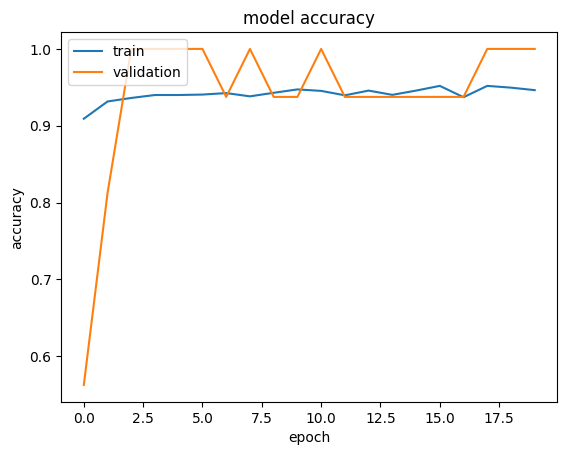

In [ ]:
plot_hist(hist)

The second step is to unfreeze a number of layers and fit the model with a lower learning rate; this is known as fine-tuning. In this example, we unfreeze te top 20 layers, however depending on the dataset, you may just want to unfreeze a subset of all layers.

This step provides a very limited gain in accuracy in this case, but it can make a huge difference in other cases, because when using pretrained weights on a dataset that is more different from ImageNet, this fine-tuning step is critical because the feature extractor must also be adjusted significantly.

In [ ]:
# We unfreeze the top 20 layers while leaving BatchNorm layers frozen
for layer in model.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["binary_accuracy"])

epochs = 10
hist = model.fit(ds_train,
                 epochs=epochs,
                 steps_per_epoch=ds_train.samples//ds_train.batch_size,
                 validation_data=ds_val,
                 validation_steps=ds_val.samples//ds_val.batch_size,
                 verbose=1)

Epoch 1/10
163/163 [==============================] - 163s 825ms/step - loss: 0.1095 - binary_accuracy: 0.9605 - val_loss: 0.0372 - val_binary_accuracy: 1.0000
Epoch 2/10
163/163 [==============================] - 130s 794ms/step - loss: 0.1037 - binary_accuracy: 0.9613 - val_loss: 0.0457 - val_binary_accuracy: 1.0000
Epoch 3/10
163/163 [==============================] - 130s 794ms/step - loss: 0.1044 - binary_accuracy: 0.9613 - val_loss: 0.0403 - val_binary_accuracy: 1.0000
Epoch 4/10
163/163 [==============================] - 131s 803ms/step - loss: 0.1075 - binary_accuracy: 0.9609 - val_loss: 0.0552 - val_binary_accuracy: 1.0000
Epoch 5/10
163/163 [==============================] - 128s 782ms/step - loss: 0.1057 - binary_accuracy: 0.9618 - val_loss: 0.1195 - val_binary_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 131s 802ms/step - loss: 0.0888 - binary_accuracy: 0.9645 - val_loss: 0.1195 - val_binary_accuracy: 0.9375
Epoch 7/10
163/163 [====================

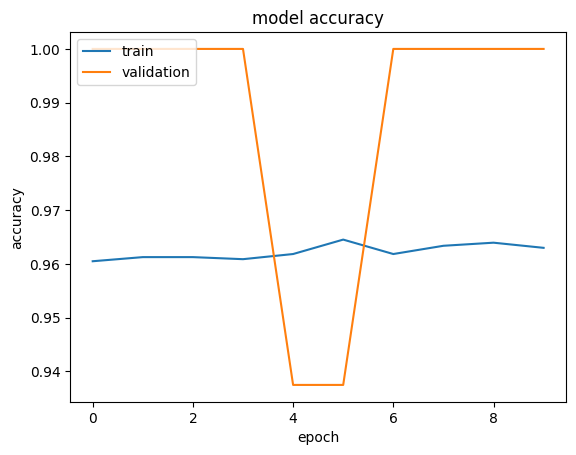

In [ ]:
plot_hist(hist)

# **Evaluation**

In [ ]:
#Evaluate
result = model.evaluate(ds_test, steps=ds_test.samples//ds_test.batch_size, verbose = 1)

print('Test loss:', result[0])
print('Test accuracy:', result[1])

19/19 [==============================] - 8s 416ms/step - loss: 0.2791 - binary_accuracy: 0.9112
Test loss: 0.27906569838523865
Test accuracy: 0.9111841917037964


As we can see, our model has reached an accuracy of 91%. Which is not bad considering the low effort that we've put in.

Comparing this result with smaller versions of this model we see that it's not a very significant improvement, scpecially considering the much longer training time needed. Although is an impovement after all.